In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_singlegrid_quarter'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5131bd3ba8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f513078d9e8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.679    |
| time/              |          |
|    fps             | 378      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 36 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.667       |
| time/                   |             |
|    fps                  | 483         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                 

policy iteration runtime: 26 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.726      |
| time/                   |            |
|    fps                  | 480        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05085764 |
|    clip_fraction        | 0.485      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.07       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0631    |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0447    |
|    std                  | 0.181      |
|    value_loss           | 

policy iteration runtime: 27 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.744       |
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.048280817 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.37        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0503     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0428     |
|    std                  | 

policy iteration runtime: 23 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.772       |
| time/                   |             |
|    fps                  | 481         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058969725 |
|    clip_fraction        | 0.552       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.61        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000243   |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0431     |
|    std                  |

policy iteration runtime: 31 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.781       |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.059190728 |
|    clip_fraction        | 0.58        |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.03        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0412     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0407     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.797      |
| time/                   |            |
|    fps                  | 481        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07169143 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.55       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0213    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0369    |
|    std                  | 0.17       |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.811      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07091652 |
|    clip_fraction        | 0.585      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.11       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0485    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0322    |
|    std                  | 0.166      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.817      |
| time/                   |            |
|    fps                  | 480        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07097624 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0584    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0304    |
|    std                  | 0.159      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.822      |
| time/                   |            |
|    fps                  | 485        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06982125 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0563    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0245    |
|    std                  | 0.155      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09430981 |
|    clip_fraction        | 0.608      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0428    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0217    |
|    std                  | 0.15       |
|    

policy iteration runtime: 29 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.082806155 |
|    clip_fraction        | 0.612       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.1        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0101      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0213     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 485        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06973883 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0317    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0185    |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 491        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08045194 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0329    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0186    |
|    std                  | 0.14       |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.831       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.104896165 |
|    clip_fraction        | 0.614       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.2        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0378     |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0186     |
|    std                  | 0.138       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 488        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10436082 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.6       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.052     |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0194    |
|    std                  | 0.135      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 483        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10746379 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00271   |
|    n_updates            | 2420       |
|    policy_gradient_loss | -0.0161    |
|    std                  | 0.134      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 492        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09297703 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13         |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0846    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10726335 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.062     |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0125    |
|    std                  | 0.131      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 490        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11063252 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0286    |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.0147    |
|    std                  | 0.129      |
|    

policy iteration runtime: 24 seconds

Total episode rollouts: 78336

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.833       |
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.103132464 |
|    clip_fraction        | 0.633       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.8        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.074       |
|    n_updates            | 3060        |
|    policy_gradient_loss | -0.0126     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 82432

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 485        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14252767 |
|    clip_fraction        | 0.647      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.137      |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.125      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 86528

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.833       |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.105232455 |
|    clip_fraction        | 0.652       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.6        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0199     |
|    n_updates            | 3380        |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.123       |
|    va

policy iteration runtime: 26 seconds

Total episode rollouts: 90624

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 481        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11886346 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0011     |
|    n_updates            | 3540       |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.121      |
|    value_loss           |

policy iteration runtime: 30 seconds

Total episode rollouts: 94720

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 486        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14241174 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0512    |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.12       |
|    value_loss           |

policy iteration runtime: 30 seconds

Total episode rollouts: 98816

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 494        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14423244 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00197    |
|    n_updates            | 3860       |
|    policy_gradient_loss | -0.0105    |
|    std                  | 0.118      |
|    value_loss           |

policy iteration runtime: 27 seconds

Total episode rollouts: 102912

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 476        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13425244 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0141    |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.00842   |
|    std                  | 0.117      |
|    value_loss           

policy iteration runtime: 26 seconds

Total episode rollouts: 107008

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 474        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13327986 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0397    |
|    n_updates            | 4180       |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 23 seconds

Total episode rollouts: 111104

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.834     |
| time/                   |           |
|    fps                  | 461       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1588575 |
|    clip_fraction        | 0.67      |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.8      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.043    |
|    n_updates            | 4340      |
|    policy_gradient_loss | -0.00608  |
|    std                  | 0.1

policy iteration runtime: 25 seconds

Total episode rollouts: 115200

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13355605 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0404     |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.117      |
|    value_loss           

policy iteration runtime: 24 seconds

Total episode rollouts: 119296

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 482        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13503084 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0487    |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.0031    |
|    std                  | 0.116      |
|    value_loss           

policy iteration runtime: 24 seconds

Total episode rollouts: 123392

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14160173 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0163    |
|    n_updates            | 4820       |
|    policy_gradient_loss | -0.00926   |
|    std                  | 0.117      |
|   

policy iteration runtime: 24 seconds

Total episode rollouts: 127488

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14368112 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0355    |
|    n_updates            | 4980       |
|    policy_gradient_loss | -0.0101    |
|    std                  | 0.117      |
|   

policy iteration runtime: 27 seconds

Total episode rollouts: 131584

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.834       |
| time/                   |             |
|    fps                  | 461         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.124090075 |
|    clip_fraction        | 0.664       |
|    clip_range           | 0.15        |
|    entropy_loss         | 15.9        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0117     |
|    n_updates            | 5140        |
|    policy_gradient_loss | -0.00873    |
|    std                  | 0.116       |
|    v

policy iteration runtime: 27 seconds

Total episode rollouts: 135680

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 483        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12657161 |
|    clip_fraction        | 0.68       |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0281     |
|    n_updates            | 5300       |
|    policy_gradient_loss | -0.0119    |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 26 seconds

Total episode rollouts: 139776

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 488        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14324418 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00389   |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.00833   |
|    std                  | 0.116      |
|    value_loss           

policy iteration runtime: 30 seconds

Total episode rollouts: 143872

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 479        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13688594 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0331    |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.0108    |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 31 seconds

Total episode rollouts: 147968

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 486        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13561633 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0245    |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.00659   |
|    std                  | 0.115      |
|    value_loss           

<IPython.core.display.Javascript object>


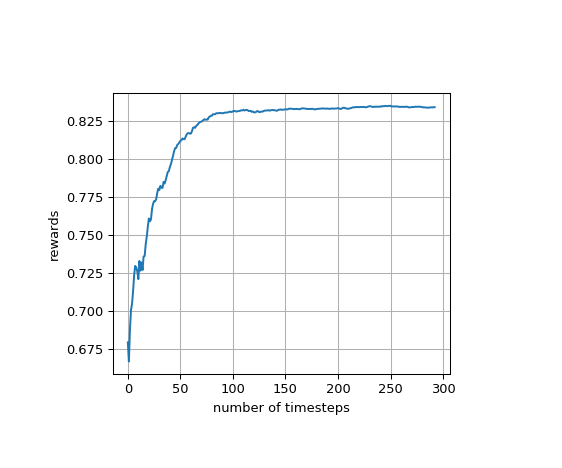

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f511c0e6c88> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f510414dac8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.671     |
| time/                   |           |
|    fps                  | 445       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1526892 |
|    clip_fraction        | 0.669     |
|    clip_range           | 0.15      |
|    entropy_loss         | 16.1      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0864   |
|    n_updates            | 5860      |
|    policy_gradient_loss | 0.000714  |
|    std                  | 0.115     |
|    value_loss           | 0.000644  |
---------------------------------------
policy iterati

policy iteration runtime: 26 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.726       |
| time/                   |             |
|    fps                  | 461         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.043623336 |
|    clip_fraction        | 0.498       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.04        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0403     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0475     |
|    std                  | 

policy iteration runtime: 26 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.731     |
| time/                   |           |
|    fps                  | 468       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0551486 |
|    clip_fraction        | 0.51      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.24      |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0647   |
|    n_updates            | 320       |
|    policy_gradient_loss | -0.0444   |
|    std                  | 0.18      |
|    value_loss           | 0.0014    |
--------

policy iteration runtime: 26 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.745       |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.056733884 |
|    clip_fraction        | 0.546       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.67        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0635     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0432     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.756     |
| time/                   |           |
|    fps                  | 457       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0666964 |
|    clip_fraction        | 0.57      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.97      |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0621   |
|    n_updates            | 640       |
|    policy_gradient_loss | -0.0435   |
|    std                  | 0.174     |
|    value_loss          

policy iteration runtime: 26 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.77       |
| time/                   |            |
|    fps                  | 468        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07357506 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.38       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0834    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0399    |
|    std                  | 0.171      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.791     |
| time/                   |           |
|    fps                  | 478       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0922491 |
|    clip_fraction        | 0.594     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.88      |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0583   |
|    n_updates            | 960       |
|    policy_gradient_loss | -0.0338   |
|    std                  | 0.167     |
|    value_loss          

policy iteration runtime: 31 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.812       |
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083682366 |
|    clip_fraction        | 0.614       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.58        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0335     |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0345     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.825      |
| time/                   |            |
|    fps                  | 482        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07787631 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.4        |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00189   |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.156      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 489         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.090517186 |
|    clip_fraction        | 0.603       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0208     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0181     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 470        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09132691 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0557     |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0149    |
|    std                  | 0.146      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.833       |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.086456716 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.4        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0332     |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0134     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.835     |
| time/                   |           |
|    fps                  | 466       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1063107 |
|    clip_fraction        | 0.614     |
|    clip_range           | 0.15      |
|    entropy_loss         | 11.9      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0178    |
|    n_updates            | 1920      |
|    policy_gradient_loss | -0.0117   |
|    std                  | 0.139     |
|    value_loss          

policy iteration runtime: 27 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.834       |
| time/                   |             |
|    fps                  | 471         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.069924295 |
|    clip_fraction        | 0.628       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.2        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0133     |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.137       |
|    va

policy iteration runtime: 26 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09665093 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.4       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.05      |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.136      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 468        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10976436 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0828     |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.133      |
|    

policy iteration runtime: 25 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.835       |
| time/                   |             |
|    fps                  | 457         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.117026135 |
|    clip_fraction        | 0.629       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.9        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0696     |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.133       |
|    va

policy iteration runtime: 25 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.835    |
| time/                   |          |
|    fps                  | 462      |
|    iterations           | 1        |
|    time_elapsed         | 5        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.108979 |
|    clip_fraction        | 0.645    |
|    clip_range           | 0.15     |
|    entropy_loss         | 13.2     |
|    explained_variance   | 0.994    |
|    learning_rate        | 0.0001   |
|    loss                 | 0.0169   |
|    n_updates            | 2720     |
|    policy_gradient_loss | -0.00995 |
|    std                  | 0.131    |
|    value_loss           | 0.000361 |
----------------------------

policy iteration runtime: 24 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 484        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09886112 |
|    clip_fraction        | 0.638      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0576    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.00915   |
|    std                  | 0.13       |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11670282 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0212     |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.00456   |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 479        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10909806 |
|    clip_fraction        | 0.646      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.8       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00165   |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.00388   |
|    std                  | 0.127      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 471        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11361285 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0611    |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.00733   |
|    std                  | 0.125      |
|    

Early stopping at step 19 due to reaching max kl: 0.16
policy iteration runtime: 26 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 471        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16354816 |
|    clip_fraction        | 0.645      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0158    |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.00714   |
|    std     

policy iteration runtime: 33 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.838       |
| time/                   |             |
|    fps                  | 475         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.124638036 |
|    clip_fraction        | 0.668       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.6        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0211     |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.122       |
|    va

policy iteration runtime: 27 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 477        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13912371 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0254    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.00464   |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 24 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 490        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13104811 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0177    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.00413   |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 26 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.838     |
| time/                   |           |
|    fps                  | 477       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1342648 |
|    clip_fraction        | 0.677     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.9      |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.041    |
|    n_updates            | 4160      |
|    policy_gradient_loss | -0.000102 |
|    std                  | 0.121     |
|    value_loss           | 0.000367  |
------

policy iteration runtime: 33 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.837       |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.103334345 |
|    clip_fraction        | 0.653       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.9        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0392     |
|    n_updates            | 4320        |
|    policy_gradient_loss | -0.00165    |
|    std                  | 0.121       |
|    v

policy iteration runtime: 26 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 480        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12887283 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.029      |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.00362   |
|    std                  | 0.121      |
|    value_loss           

policy iteration runtime: 27 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 483        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13557234 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0441    |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.00355   |
|    std                  | 0.121      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.17
policy iteration runtime: 24 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 486        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16609952 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0312     |
|    n_updates            | 4800       |
|    policy_gradient_loss | 0.0

Early stopping at step 17 due to reaching max kl: 0.16
policy iteration runtime: 23 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15501444 |
|    clip_fraction        | 0.681      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0372     |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 26 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 488        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15305206 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00622   |
|    n_updates            | 5120       |
|    policy_gradient_loss | 0.00593    |
|    std    

policy iteration runtime: 26 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 469        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14507274 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0569     |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.00463   |
|    std                  | 0.119      |
|    value_loss           

Early stopping at step 12 due to reaching max kl: 0.16
policy iteration runtime: 18 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 476        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15837541 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.088      |
|    n_updates            | 5440       |
|    policy_gradient_loss | 0.00308    |
|    std    

Early stopping at step 13 due to reaching max kl: 0.16
policy iteration runtime: 19 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 491        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15837774 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0332    |
|    n_updates            | 5600       |
|    policy_gradient_loss | 0.00868    |
|    std    

policy iteration runtime: 25 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 471        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12563357 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0166    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.00349   |
|    std                  | 0.119      |
|   

<IPython.core.display.Javascript object>


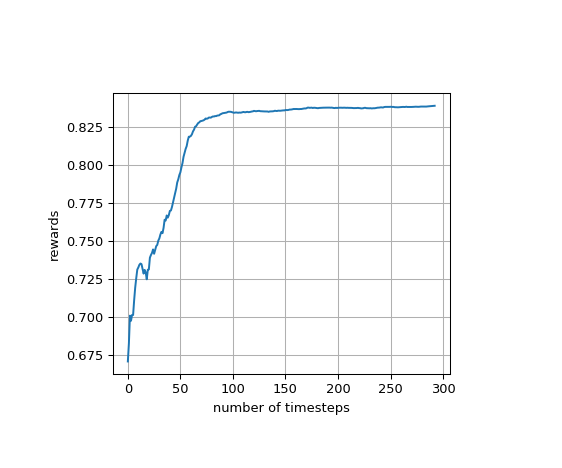

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f511c0bbb38> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f51040bbb00>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.68       |
| time/                   |            |
|    fps                  | 440        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15199842 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00998   |
|    n_updates            | 5860       |
|    policy_gradient_loss | 0.00238    |
|    std                  | 0.119      |
|    value_loss           | 0.000344   |
---------------------------------

policy iteration runtime: 26 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.719       |
| time/                   |             |
|    fps                  | 487         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.041048933 |
|    clip_fraction        | 0.485       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.9         |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0689     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0463     |
|    std                  | 0.183       |
|    val

policy iteration runtime: 27 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.741      |
| time/                   |            |
|    fps                  | 463        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04647106 |
|    clip_fraction        | 0.523      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.21       |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0857    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0442    |
|    std                  | 0.18       |
|    value_loss           | 

policy iteration runtime: 26 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.762     |
| time/                   |           |
|    fps                  | 469       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0578928 |
|    clip_fraction        | 0.548     |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.57      |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0349   |
|    n_updates            | 480       |
|    policy_gradient_loss | -0.0449   |
|    std                  | 0.177     |
|    value_loss          

policy iteration runtime: 25 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 471         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058915943 |
|    clip_fraction        | 0.574       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.02        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00935     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0415     |
|    std                  |

policy iteration runtime: 27 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.79       |
| time/                   |            |
|    fps                  | 467        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06914873 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.64       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0381    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0374    |
|    std                  | 0.169      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.799       |
| time/                   |             |
|    fps                  | 467         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.070667684 |
|    clip_fraction        | 0.593       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.38        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0254     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0338     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.807      |
| time/                   |            |
|    fps                  | 477        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08583589 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0376    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0335    |
|    std                  | 0.159      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.813      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07361041 |
|    clip_fraction        | 0.613      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0646    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.154      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.818       |
| time/                   |             |
|    fps                  | 469         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.089062504 |
|    clip_fraction        | 0.611       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0416     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0232     |
|    std                  |

policy iteration runtime: 25 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.821      |
| time/                   |            |
|    fps                  | 480        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08019618 |
|    clip_fraction        | 0.617      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0501    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0211    |
|    std                  | 0.146      |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.823      |
| time/                   |            |
|    fps                  | 464        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10313401 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.4       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0191     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.023     |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.825       |
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.095734775 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.8        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0521     |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.139       |
|    va

policy iteration runtime: 25 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.825       |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.081894204 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.3        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0167     |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0154     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.828       |
| time/                   |             |
|    fps                  | 483         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.086091906 |
|    clip_fraction        | 0.632       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.7        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0632     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0173     |
|    std                  |

policy iteration runtime: 32 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.829      |
| time/                   |            |
|    fps                  | 497        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10887082 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0325    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0141    |
|    std                  | 0.132      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11685958 |
|    clip_fraction        | 0.643      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00831    |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0148    |
|    std                  | 0.129      |
|    value_loss           |

policy iteration runtime: 26 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.83        |
| time/                   |             |
|    fps                  | 481         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.110379145 |
|    clip_fraction        | 0.655       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14          |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0227     |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.016      |
|    std                  |

policy iteration runtime: 31 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.83        |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.109912336 |
|    clip_fraction        | 0.639       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.3        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0623     |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.0126     |
|    std                  | 0.125       |
|    va

policy iteration runtime: 26 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 474        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11275466 |
|    clip_fraction        | 0.655      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0168     |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.00992   |
|    std                  | 0.123      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.831     |
| time/                   |           |
|    fps                  | 484       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1268475 |
|    clip_fraction        | 0.661     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.7      |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0249   |
|    n_updates            | 3200      |
|    policy_gradient_loss | -0.0155   |
|    std                  | 0.122     |
|    value_loss           | 0.000599  |
-------

policy iteration runtime: 26 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 462        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13187185 |
|    clip_fraction        | 0.655      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0103     |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0128    |
|    std                  | 0.121      |
|    

Early stopping at step 10 due to reaching max kl: 0.16
policy iteration runtime: 16 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 478        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15845576 |
|    clip_fraction        | 0.645      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0494     |
|    n_updates            | 3520       |
|    policy_gradient_loss | 0.00

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 21 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.833     |
| time/                   |           |
|    fps                  | 482       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1537338 |
|    clip_fraction        | 0.656     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.3      |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0172   |
|    n_updates            | 3680      |
|    policy_gradient_loss | -0.00945  |
|    std                  | 0.11

policy iteration runtime: 29 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 481        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12510164 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0163    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0107    |
|    std                  | 0.118      |
|    value_loss           |

Early stopping at step 19 due to reaching max kl: 0.16
policy iteration runtime: 28 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 486        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16479978 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0202    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0116    |
|    std    

Early stopping at step 19 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 476        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15731676 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0105    |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.

policy iteration runtime: 25 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14335798 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0175    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.0107    |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.16
policy iteration runtime: 20 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 470        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15903075 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0495    |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.

policy iteration runtime: 27 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 474        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13400614 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0744    |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.116      |
|   

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 19 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 480        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15367013 |
|    clip_fraction        | 0.652      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0571     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.

Early stopping at step 18 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 467        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15222529 |
|    clip_fraction        | 0.685      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0283    |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.0126    |
|    std    

policy iteration runtime: 25 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 477        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13510063 |
|    clip_fraction        | 0.686      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.3       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00143   |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.0108    |
|    std                  | 0.114      |
|   

policy iteration runtime: 25 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 475        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14189689 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0635     |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.115      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 23 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 471        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15989316 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.3       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00248    |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.000772  |
|    std    

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 19 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 492        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15310608 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00493   |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.0022    |
|    std    

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 481        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15018006 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0253     |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.

<IPython.core.display.Javascript object>


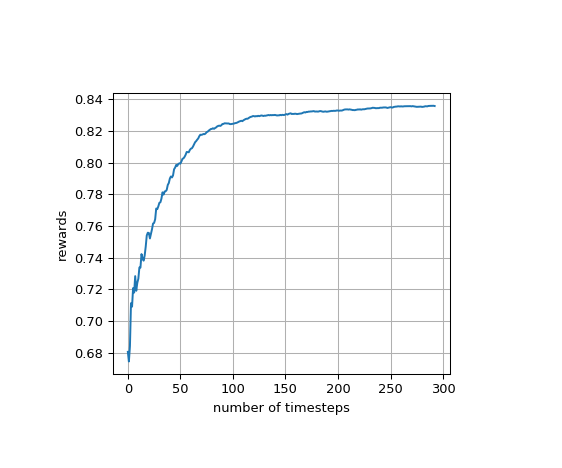

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.3, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25],
                                episode_limit_array=[150000], 
                                log_dir=log_dir,
                                seed=seed)